# Using database query to reduce memory load

Yangkang Chen<br>
Oct 10, 2025

This notebook is to demonstrate how to use the path to a `duckdb` database or `parquet` file as input to reduce the memory when training large amount of ensembles across processors (n_jobs>1).

You will need to know some very basic SQL syntax to fully understand this notebook.

## Examples

In [1]:
import os
import sys 

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import gc
pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')


In [2]:
%load_ext autoreload
%autoreload 2

### Download data

#### Training/test data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

In [3]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


### Prediction set

Prediction set are used to feed into a trained AdaSTEM model and make prediction: at some location, at some day of year, given the environmental variables, how many Mallard individual do I expected to observe?

The prediction set will be loaded after the model is trained.

Download the prediction set from: https://figshare.com/articles/dataset/Predset_2020_csv/24124980

**Caveat: The file is about 700MB.**

### Get X and y

In [4]:
X = data.drop('count', axis=1)
y = data[['count']]


In [5]:
X.head()

,longitude,latitude,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
0,-83.472224,8.859308,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,0.003156,0.001451,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.0,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720
1,-2.687724,43.373323,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,0.004512,0.000081,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063
2,-89.884770,35.087255,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,0.005878,0.000044,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278
3,-99.216873,31.218510,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,0.000791,0.000052,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
4,-124.426730,43.065847,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,0.000211,0.000147,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.0,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754


The features include:

- spatial coordinates:
  - `longitude` and `latitude` (used for indexing, not actual training)
    
- Temporal coordinate:
  - day of year (`DOY`): used for both indexing and training

- Sampling parameters: These are parameters quantifying how the observation was made
  - `duration_minutes`: How long the observation was conducted
  - Observation protocol: `Traveling`, `Stationary`, or `Area`
  -  `effort_distance_km`: how far have one traveled
  -  `number_observers`: How many observers are there in the group
  - `obsvr_species_count`: How many bird species have the birder observed in the past
  - `time_observation_started_minute_of_day`: When did the birder start birding

- Topological features:
  - Features of elevation: `elevation_mean`
  - Features of slope magnitude and direction: `slope_mean`, `eastness_mean`, `northness_mean`

- Bioclimate features:
  - Summaries of yearly temperature and precipitation: from `bio1` to `bio19`

- Land cover features:
  - Summaries of land cover, percentage of cover. For example, `closed_shrublands`,  `urban_and_built_up_lands`.
  - `entropy`: Entropy of land cover


As you can see, the environmental variables are almost static. However, dynamic features (e.g., daily temperature) is fully supported as input. See [Tips for data types](https://chenyangkang.github.io/stemflow/Tips/Tips_for_data_types.html) for details.
  
  
 

### First thing first: Spatiotemporal train test split

In [6]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                        Spatio1 = 'longitude',
                                                        Spatio2 = 'latitude',
                                                        Temporal1 = 'DOY',
                                                        Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                        random_state=42, test_size=0.3)


### Initiate AdaSTEM hurdle model

In [7]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


We first import the models. Although some classes are not used, I imported them for complete showcase of function.

In [8]:
## "hurdle in Ada"
model = AdaSTEMRegressor(
    base_model=Hurdle(
        classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
        regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
    ),                                      # hurdel model for zero-inflated problem (e.g., count)
    task='hurdle',
    save_gridding_plot = True,
    ensemble_fold=10,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
    min_ensemble_required=7,                # Only points covered by > 7 ensembles will be predicted
    grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
    grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
    temporal_start=1,                       # The next 4 params define the temporal sliding window
    temporal_end=366,                            
    temporal_step=25,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
    temporal_bin_interval=50,               # Each window will contain data of 50 DOY
    points_lower_threshold=50,              # Only stixels with more than 50 samples are trained
    Spatio1='longitude',                    # The next three params define the name of 
    Spatio2='latitude',                     # spatial coordinates shown in the dataframe
    Temporal1='DOY',
    use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
    n_jobs=5,                               # Not using parallel computing
    random_state=42,                        # The random state makes the gridding process reproducible
    lazy_loading=True                       # Using lazy loading for large ensemble amount (e.g., >20 ensembles). 
                                            # -- Each trained ensemble will be saved into disk and will only be loaded if needed (e.g. for prediction).
)


### "Traditional" fit with pandas object

In [9]:
model.fit(X_train, y_train, verbosity=1)


Training: 100%|██████████| 10/10 [02:08<00:00, 12.84s/it]


AdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            feature_weights=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interacti...
                                                          n_estimators=None,
                                                          n_jobs=1,
                                                          num_parallel_tree=None, ...)),
                 lazy_loading=True,
                 lazy_loading_dir='/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/stemflow_model_Fb08mZvfpcZ7jlWk',
                 n_jobs=5, plot_xlims=(-179.8730564, 178.7306634),
                 plot_ylims=(-66.6730616, 73.0109413), random_state=42,
                 save_gridding_plot=True, stixel_training_size_threshold=50,
                 task='hurdle', temporal_step=25)

### Dump data into duckdb database

[Duckdb](www.duckdb.org) is an analytical in-process SQL database management system. It is light-weighted, precompiled, multilingual, and fast. Our goal is to dump our training and test dataset into separate duckdb datasets, so that each single processor in the parallel computing process can query it individually and get the needed rows/columns, without loading the whole dataframe into memory.


In [10]:
import tempfile, duckdb
from stemflow.utils.generate_random import generate_random_saving_code

# We first create a temporary folder to save our database. However, you can save this database into a more permanent location if you want to use it in a long run.
tmp_dir = os.path.join(tempfile.gettempdir(), f'{generate_random_saving_code()}')
os.makedirs(tmp_dir)

Now, we make a copy of each data, save the dataframe indexes as a variable/column called "__index_level_0__". This index column is necessary for AdaSTEM to process and query so make sure you have them in the `duckdb` file. If you are not creating this dataframe from a pandas object, but from a parquet file, you may not need this since parquet file may automatically save the index as "__index_level_0__" so when it is loaded to a duckdb it will preserve that column. See duckdb official documentation for details.

In [11]:
# Make a cpy
X_train_new = X_train.copy()
X_test_new = X_test.copy()
y_train_new = y_train.copy()
y_test_new = y_test.copy()

# Make the index an actual column in that dataframe
X_train_new['__index_level_0__'] = X_train_new.index
X_test_new['__index_level_0__'] = X_test_new.index
y_train_new['__index_level_0__'] = y_train_new.index
y_test_new['__index_level_0__'] = y_test_new.index

# Dump X_train to duckdb
target_X_train_path = os.path.join(tmp_dir, 'X_train.duckdb')
with duckdb.connect(target_X_train_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM X_train_new;") # I use tmp as the table name, but you can use any. Make sure there is only one table in this .duckdb file
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it
    con.execute("CREATE INDEX IF NOT EXISTS idx_doy ON tmp(DOY);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_longitude ON tmp(longitude);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_latitude ON tmp(latitude);")

target_y_train_path = os.path.join(tmp_dir, 'y_train.duckdb')
with duckdb.connect(target_y_train_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM y_train_new;")
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it

target_X_test_path = os.path.join(tmp_dir, 'X_test.duckdb')

with duckdb.connect(target_X_test_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM X_test_new;")
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it
    con.execute("CREATE INDEX IF NOT EXISTS idx_doy ON tmp(DOY);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_longitude ON tmp(longitude);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_latitude ON tmp(latitude);")

target_y_test_path = os.path.join(tmp_dir, 'y_test.duckdb')
with duckdb.connect(target_y_test_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM y_test_new;")
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it


Now we can take a look at what the saved data is like in duckdb

In [12]:
con = duckdb.connect(target_X_train_path)
con.sql("SELECT * from tmp limit 10;").df()


,longitude,latitude,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy,__index_level_0__
0,-83.472224,8.859308,22,300.0,1,0,0,4.828,5.0,34.0,476,7.555556,0.758156,0.036083,-0.021484,24.883502,5.174890,59.628088,93.482247,30.529131,21.850519,8.678612,24.302626,26.536822,26.213334,23.864924,0.720487,0.127594,3.155662e-03,1.450605e-03,0.332425,0.026401,0.044218,0.260672,0.0,0.000000,0.0,0.000000,0.0,0.138889,0.000000,0.000000,0.000000,0.0,0.0,0.777778,0.000000,0.000000,0.083333,0.000000,0.676720,0
1,-2.687724,43.373323,290,90.0,1,0,0,0.570,2.0,151.0,1075,30.833336,3.376527,0.050544,-0.099299,14.107917,5.224109,31.174167,376.543853,23.219421,6.461607,16.757814,9.048385,19.092725,19.236082,9.287841,0.171423,0.035598,4.512316e-03,8.061694e-05,0.084657,0.018400,0.030210,0.065007,0.0,0.000000,0.0,0.000000,0.0,0.333333,0.000000,0.000000,0.083333,0.0,0.0,0.000000,0.194444,0.027778,0.000000,0.361111,1.359063,1
2,-89.884770,35.087255,141,10.0,0,1,0,-1.000,2.0,678.0,575,91.777780,0.558100,-0.187924,-0.269078,17.396487,8.673912,28.688889,718.996078,32.948335,2.713938,30.234397,14.741099,13.759220,26.795849,7.747272,0.187089,0.031802,5.878473e-03,4.407694e-05,0.073328,0.026618,0.039616,0.059673,0.0,0.055556,0.0,0.000000,0.0,0.000000,0.000000,0.305556,0.000000,0.0,0.0,0.000000,0.527778,0.000000,0.000000,0.111111,1.104278,2
3,-99.216873,31.218510,104,9.0,1,0,0,0.805,2.0,976.0,657,553.166700,0.856235,-0.347514,-0.342971,20.740836,10.665164,35.409121,666.796919,35.909941,5.790119,30.119822,18.444353,30.734456,29.546417,11.701038,0.084375,0.025289,7.913023e-04,5.175100e-05,0.052866,0.004096,0.006064,0.015965,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,3
4,-124.426730,43.065847,96,30.0,1,0,0,0.161,2.0,654.0,600,6.500000,0.491816,-0.347794,-0.007017,11.822340,6.766870,35.672897,396.157833,22.608788,3.639569,18.969219,8.184412,16.290802,17.258721,7.319234,0.144122,0.044062,2.113682e-04,1.466850e-04,0.089238,0.004435,0.004822,0.040621,0.0,0.000000,0.0,0.000000,0.0,0.361111,0.166667,0.000000,0.472222,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.020754,4
5,-70.327847,-27.369757,148,10.0,0,1,0,-1.000,1.0,267.0,546,415.722260,5.763536,-0.229882,0.096145,19.441376,10.728234,49.180151,298.789744,27.961119,6.146965,21.814154,14.795449,21.205220,22.725056,14.837230,0.002105,0.001414,-2.220446e-16,1.447865e-07,0.001825,0.000004,0.000221,0.001706,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,6
6,-92.709547,47.849505,77,79.0,0,1,0,-1.000,1.0,60.0,474,403.000000,0.530737,0.135500,-0.175161,5.376244,7.990657,19.404248,1116.178065,26.669454,-14.510481,41.179935,20.181890,-10.006707,20.489164,-8.870193,0.071835,0.010339,1.880060e-03,5.735011e-06,0.027664,0.009967,0.026256,0.011533,0.0,0.000000,0.0,0.305556,0.0,0.000000,0.000000,0.000000,0.583333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.920825,8
7,-74.832765,41.072531,22,10.0,0,1,0,-1.000,1.0,586.0,968,176.944460,2.271088,-0.051615,0.043608,11.909730,7.957276,25.180977,826.112869,29.865481,-1.734867,31.600348,1.373340,1.535685,23.182224,1.642667,0.143598,0.019284,7.318247e-03,1.086039e-05,0.050504,0.024997,0.028133,0.038676,0.0,0.000000,0.0,0.305556,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.000000,0.638889,0.809088,9
8,14.

In [13]:
con.close() # Always rememer to close the connection

And you can see that "__index_level_0__" is in the columns.

We then fit the model.

Instead of calling .fit(X_train, y_train) to pass in pd.DataFrame file, now we just need to pass in "target_X_train_path" and "target_y_train_path", which are strings, to indicate the databases that have those training data.

### Using duckdb as input


In [14]:
# columns of X_train should only contain predictors and Spatio-temporal indicators (Spatio1, Spatio2, Temporal1)
model.fit(target_X_train_path, target_y_train_path, verbosity=1, overwrite=True)  # overwrite=True allows us to over write the model files trained in the previous round fitting



Training: 100%|██████████| 10/10 [03:02<00:00, 18.24s/it]


AdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            feature_weights=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interacti...
                                                          n_estimators=None,
                                                          n_jobs=1,
                                                          num_parallel_tree=None, ...)),
                 lazy_loading=True,
                 lazy_loading_dir='/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/stemflow_model_Fb08mZvfpcZ7jlWk',
                 n_jobs=5, plot_xlims=(-179.8730564, 178.7306634),
                 plot_ylims=(-66.6730616, 73.0109413), random_state=42,
                 save_gridding_plot=True, stixel_training_size_threshold=50,
                 task='hurdle', temporal_step=25)

As you can see, when using duckdb as input, the speed will decrease because we are sacrificing speed for lower memory usage by iteratively reading data from disk, instead of from memory.

However, we can also take a middle place of the two worlds by loading only the data for one temporal windows into the memory. For example, if your temporal window step is 50 days and your total data contains 365 days, then one temporal window means 50/365=0.13 times memory compared to loading the whole dataframe. This could facilitate the stixel query. This can be done by:

In [15]:
model.fit(target_X_train_path, target_y_train_path, verbosity=1, temporal_window_prequery=True, overwrite=True) # overwrite=True allows us to over write the model files trained in the previous round fitting


Training: 100%|██████████| 10/10 [02:09<00:00, 12.91s/it]


AdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            feature_weights=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interacti...
                                                          n_estimators=None,
                                                          n_jobs=1,
                                                          num_parallel_tree=None, ...)),
                 lazy_loading=True,
                 lazy_loading_dir='/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/stemflow_model_Fb08mZvfpcZ7jlWk',
                 n_jobs=5, plot_xlims=(-179.8730564, 178.7306634),
                 plot_ylims=(-66.6730616, 73.0109413), random_state=42,
                 save_gridding_plot=True, stixel_training_size_threshold=50,
                 task='hurdle', temporal_step=25)

### Using parquet as input

In [16]:
X_train_parquet_path = os.path.join(tmp_dir, 'X_train.parquet')
X_train.to_parquet(X_train_parquet_path, index=True)

X_test_parquet_path = os.path.join(tmp_dir, 'X_test.parquet')
X_test.to_parquet(X_test_parquet_path, index=True)

y_train_parquet_path = os.path.join(tmp_dir, 'y_train.parquet')
y_train.to_parquet(y_train_parquet_path, index=True)

y_test_parquet_path = os.path.join(tmp_dir, 'y_test.parquet')
y_test.to_parquet(y_test_parquet_path, index=True)


In [17]:
model.fit(X_train_parquet_path, y_train_parquet_path, verbosity=1, overwrite=True)


Training: 100%|██████████| 10/10 [06:27<00:00, 38.72s/it]


AdaSTEMRegressor(base_model=Hurdle(classifier=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            feature_weights=None,
                                                            gamma=None,
                                                            grow_policy=None,
                                                            importance_type=None,
                                                            interacti...
                                                          n_estimators=None,
                                                          n_jobs=1,
                                                          num_parallel_tree=None, ...)),
                 lazy_loading=True,
                 lazy_loading_dir='/var/folders/j_/w98j87ps77j1k44x5fhz3dz80000gn/T/stemflow_model_Fb08mZvfpcZ7jlWk',
                 n_jobs=5, plot_xlims=(-179.8730564, 178.7306634),
                 plot_ylims=(-66.6730616, 73.0109413), random_state=42,
                 save_gridding_plot=True, stixel_training_size_threshold=50,
                 task='hurdle', temporal_step=25)

### Compare the three method: pd.DataFrame, parquet, and duckdb
-- Speed, memory use

In [18]:
import os, time, threading, psutil

class PeakRSSMonitor:
    def __init__(self, interval=0.05, include_children=True):
        self.interval = interval
        self.include_children = include_children
        self._stop = threading.Event()
        self.samples = []

    def _collect(self):
        p = psutil.Process(os.getpid())
        while not self._stop.is_set():
            rss = p.memory_info().rss
            if self.include_children:
                for c in p.children(recursive=True):
                    try:
                        rss += c.memory_info().rss
                    except psutil.NoSuchProcess:
                        pass
            self.samples.append(rss / (1024**3))  # GB
            time.sleep(self.interval)

    def __enter__(self):
        self._t = threading.Thread(target=self._collect, daemon=True)
        self._t.start()
        return self

    def __exit__(self, exc_type, exc, tb):
        self._stop.set()
        self._t.join()

    @property
    def peak(self): 
        return max(self.samples) if self.samples else 0.0

    @property
    def average(self): 
        return (sum(self.samples) / len(self.samples)) if self.samples else 0.0
    


In [19]:
import time
from memory_profiler import memory_usage

def make_model_lazyloading(ensemble_fold, n_jobs=3, max_mem='200MB'):
    model_lazyloading = AdaSTEMRegressor(
        base_model=Hurdle(
            classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
            regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
        ),                                      # hurdel model for zero-inflated problem (e.g., count)
        task='hurdle',
        save_gridding_plot = True,
        ensemble_fold=ensemble_fold,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
        min_ensemble_required=ensemble_fold-2,                # Only points covered by > 7 ensembles will be predicted
        grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
        grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
        temporal_start=1,                       # The next 4 params define the temporal sliding window
        temporal_end=366,                            
        temporal_step=25,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
        temporal_bin_interval=50,               # Each window will contain data of 50 DOY
        points_lower_threshold=50,              # Only stixels with more than 50 samples are trained
        Spatio1='longitude',                    # The next three params define the name of 
        Spatio2='latitude',                     # spatial coordinates shown in the dataframe
        Temporal1='DOY',
        use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
        n_jobs=n_jobs,                               # Using parallel computing
        random_state=42,                        # The random state makes the gridding process reproducible
        lazy_loading=True,                       # Using lazy loading for large ensemble amount (e.g., >20 ensembles). 
        verbosity=1,                              # -- Each trained ensemble will be saved into disk and will only be loaded if needed (e.g. for prediction).
        max_mem=max_mem # Important! Set to a relatively small value so that the program will be optimized to use a small RAM
    )
    
    return model_lazyloading


def train_model(model, X_train, y_train, temporal_window_prequery=False):
    
    start_time = time.time()

    gc.collect()
    p = psutil.Process(os.getpid())
    baseline = p.memory_info().rss / 1e9

    with PeakRSSMonitor(interval=0.05, include_children=True) as mon:
        model.fit(X_train, y_train, temporal_window_prequery=temporal_window_prequery)

    peak_use = mon.peak - baseline
    average_use = mon.average - baseline

    end_time = time.time()
    
    training_time_use = end_time - start_time
    print('Training finish!')
    
    return training_time_use, peak_use, average_use
    
def test_model(model, X_test, y_test):
    
    start_time = time.time()
    
    gc.collect()
    p = psutil.Process(os.getpid())
    baseline = p.memory_info().rss / 1e9

    with PeakRSSMonitor(interval=0.05, include_children=True) as mon:
        res = model.predict(X_test)

    peak_use = mon.peak - baseline
    average_use = mon.average - baseline
    
    end_time = time.time()
    
    prediction_time_use = end_time - start_time
    print('Prediction finish!')
    
    return prediction_time_use, peak_use, average_use



## On Small dataset

We first test on this small X_train, y_train dataset, which, for duckdb database object, is about 90MB on disk.

### Run test: Training using pd.DataFrame, duckdb, and pandas. Increasing ensemble_fold

In [23]:
log_list=[]

In [24]:
ensemble_fold_list = [3, 5, 10, 20, 30]

for ensemble_fold in tqdm(ensemble_fold_list):
    
    model_lazyloading = make_model_lazyloading(ensemble_fold, 3, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train, y_train, temporal_window_prequery=False)
    
    # pd.DataFrame
    log_list.append({
        'method':'pd.DataFrame',
        'ensemble_fold':ensemble_fold,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading

    # Parquet
    model_lazyloading = make_model_lazyloading(ensemble_fold, 3, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train_parquet_path, y_train_parquet_path, temporal_window_prequery=False)
    log_list.append({
        'method':'parquet',
        'ensemble_fold':ensemble_fold,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    
    # Duckdb
    model_lazyloading = make_model_lazyloading(ensemble_fold, 3, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, target_X_train_path, target_y_train_path, temporal_window_prequery=False)
    log_list.append({
        'method':'duckdb',
        'ensemble_fold':ensemble_fold,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    
    # Duckdb but temporal_window_prequery=True
    model_lazyloading = make_model_lazyloading(ensemble_fold, 3, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, target_X_train_path, target_y_train_path, temporal_window_prequery=True)
    log_list.append({
        'method':'duckdb_temporal_window_prequery',
        'ensemble_fold':ensemble_fold,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    

  0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 3/3 [01:02<00:00, 20.75s/it]


Training finish!


Training: 100%|██████████| 3/3 [03:10<00:00, 63.52s/it]


Training finish!


Training: 100%|██████████| 3/3 [01:28<00:00, 29.34s/it]


Training finish!


Training: 100%|██████████| 3/3 [01:02<00:00, 20.74s/it]


Training finish!


Training: 100%|██████████| 5/5 [02:02<00:00, 24.51s/it]


Training finish!


Training: 100%|██████████| 5/5 [06:00<00:00, 72.07s/it]


Training finish!


Training: 100%|██████████| 5/5 [02:51<00:00, 34.22s/it]


Training finish!


Training: 100%|██████████| 5/5 [02:03<00:00, 24.65s/it]


Training finish!


Training: 100%|██████████| 10/10 [03:58<00:00, 23.85s/it]


Training finish!


Training: 100%|██████████| 10/10 [11:38<00:00, 69.81s/it]


Training finish!


Training: 100%|██████████| 10/10 [05:32<00:00, 33.24s/it]


Training finish!


Training: 100%|██████████| 10/10 [03:59<00:00, 23.96s/it]


Training finish!


Training: 100%|██████████| 20/20 [07:17<00:00, 21.88s/it]


Training finish!


Training: 100%|██████████| 20/20 [21:40<00:00, 65.05s/it]


Training finish!


Training: 100%|██████████| 20/20 [10:10<00:00, 30.53s/it]


Training finish!


Training: 100%|██████████| 20/20 [07:09<00:00, 21.46s/it]


Training finish!


Training: 100%|██████████| 30/30 [10:05<00:00, 20.18s/it]


Training finish!


Training: 100%|██████████| 30/30 [30:34<00:00, 61.17s/it]


Training finish!


Training: 100%|██████████| 30/30 [14:20<00:00, 28.69s/it]


Training finish!


Training: 100%|██████████| 30/30 [10:13<00:00, 20.45s/it]


Training finish!


In [25]:
log_df = pd.DataFrame(log_list)
log_df.to_csv('tmp_log_df_three_method_compare.csv', index=False)
log_df

,method,ensemble_fold,lazy_loading,train_time_use,peak_train_memory_use,average_train_memory_use
0,pd.DataFrame,3,True,65.488146,2.301168,2.056044
1,parquet,3,True,193.679915,4.144906,3.926959
2,duckdb,3,True,90.983905,1.921687,1.798635
3,duckdb_temporal_window_prequery,3,True,65.193367,2.327206,1.986628
4,pd.DataFrame,5,True,126.906886,1.905316,1.763405
5,parquet,5,True,365.360162,4.207586,4.050927
6,duckdb,5,True,175.770755,1.974543,1.835748
7,duckdb_temporal_window_prequery,5,True,127.790804,2.620761,2.261968
8,pd.DataFrame,10,True,245.984923,2.192719,1.963944
9,parquet,10,True,706.878777,4.307508,4.159890


### Plotting experiment results

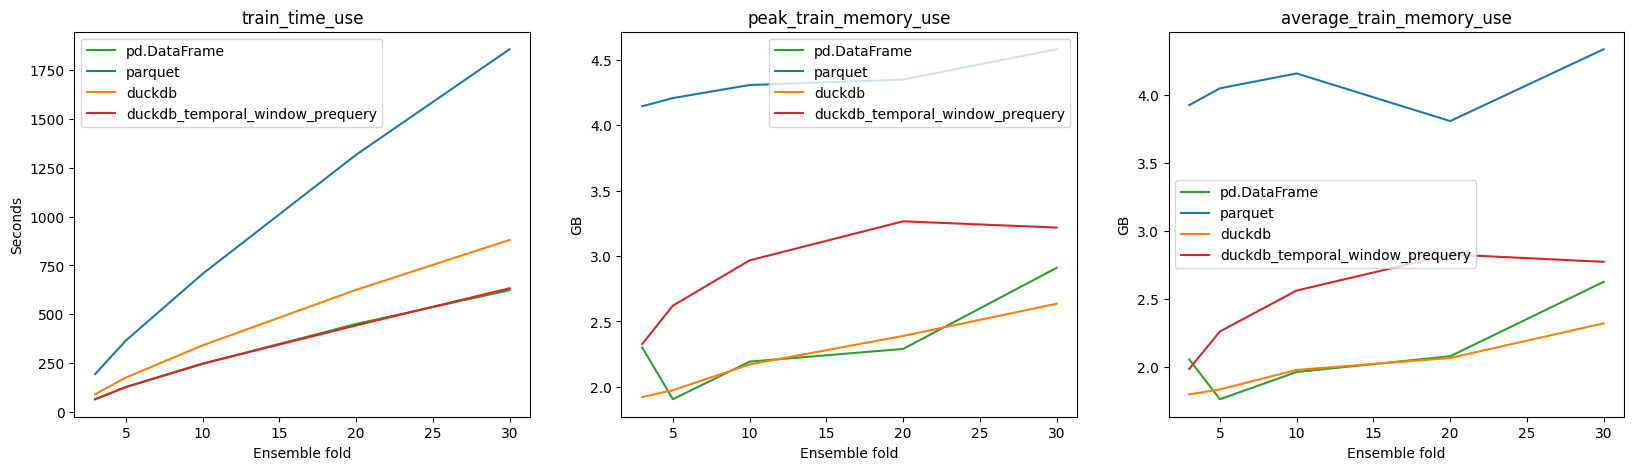

In [31]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
for var_id, var_ in enumerate(['train_time_use','peak_train_memory_use','average_train_memory_use']):
    ax[var_id%3].plot(
        log_df[log_df['method']=='pd.DataFrame']['ensemble_fold'],
        log_df[log_df['method']=='pd.DataFrame'][var_],
        label='pd.DataFrame', c='tab:green'
    )
    ax[var_id%3].plot(
        log_df[log_df['method']=='parquet']['ensemble_fold'],
        log_df[log_df['method']=='parquet'][var_],
        label='parquet', c='tab:blue'
    )

    ax[var_id%3].plot(
        log_df[log_df['method']=='duckdb']['ensemble_fold'],
        log_df[log_df['method']=='duckdb'][var_],
        label='duckdb', c='tab:orange'
    )

    ax[var_id%3].plot(
        log_df[log_df['method']=='duckdb_temporal_window_prequery']['ensemble_fold'],
        log_df[log_df['method']=='duckdb_temporal_window_prequery'][var_],
        label='duckdb_temporal_window_prequery', c='tab:red'
    )
    
    ax[var_id%3].legend()
    ax[var_id%3].set_title(var_)
    if 'time' in var_:
        ax[var_id%3].set_ylabel('Seconds')
    elif 'memory' in var_:
        ax[var_id%3].set_ylabel('GB')
    ax[var_id%3].set_xlabel('Ensemble fold')


plt.subplots_adjust(wspace=0.2, hspace=0.3)


Interestingly, duckdb does not seem to significantly reduce the memory load in this case. This is likely because the input dataset is relatively small. I anticipate that duckdb will do better on larger dataset. Parquet input seems to take a lot of memory, likely because of inner processing and indexing conducted by duckdb (under the hood, we use duckdb to read the parquet file and duckdb will create a temporary database for it *in-memory*) is adding some memory burden.

Note that this memory usage is already optimized by using `lazy_loading=True`, so that the trained model will not be stored in memory, but will be dumped to disk instead. Otherwise, the memory load will further increase.

However, this test is based on a fixed 3 n_jobs setting, which means that the number of copies of data is the same for all process (3 times, one for each processor). Therefore, the memory increases are mostly caused by more intermediate objects, not the copy of data. So this might not be the best test. We should change the n_jobs and see the results.

### Run test: Training using pd.DataFrame, duckdb, and pandas. Increasing n_jobs

In [37]:
log_list=[]

In [38]:
ensemble_fold = 20
n_jobs_list = [3, 7, 10]

for n_jobs in tqdm(n_jobs_list):
    
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train, y_train, temporal_window_prequery=False)
    
    # pd.DataFrame
    log_list.append({
        'method':'pd.DataFrame',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading

    # Parquet
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train_parquet_path, y_train_parquet_path, temporal_window_prequery=False)
    log_list.append({
        'method':'parquet',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    
    # Duckdb
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, target_X_train_path, target_y_train_path, temporal_window_prequery=False)
    log_list.append({
        'method':'duckdb',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    
    # Duckdb but temporal_window_prequery=True
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, target_X_train_path, target_y_train_path, temporal_window_prequery=True)
    log_list.append({
        'method':'duckdb_temporal_window_prequery',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    

  0%|          | 0/3 [00:00<?, ?it/s]

Training: 100%|██████████| 20/20 [07:02<00:00, 21.12s/it]


Training finish!


Training: 100%|██████████| 20/20 [21:01<00:00, 63.05s/it]


Training finish!


Training: 100%|██████████| 20/20 [09:50<00:00, 29.51s/it]


Training finish!


Training: 100%|██████████| 20/20 [07:13<00:00, 21.70s/it]


Training finish!


Training: 100%|██████████| 20/20 [04:07<00:00, 12.36s/it]


Training finish!


Training: 100%|██████████| 20/20 [10:48<00:00, 32.40s/it]


Training finish!


Training: 100%|██████████| 20/20 [04:51<00:00, 14.60s/it]


Training finish!


Training: 100%|██████████| 20/20 [03:20<00:00, 10.05s/it]


Training finish!


Training: 100%|██████████| 20/20 [02:38<00:00,  7.91s/it]


Training finish!


Training: 100%|██████████| 20/20 [07:58<00:00, 23.94s/it]


Training finish!


Training: 100%|██████████| 20/20 [03:48<00:00, 11.40s/it]


Training finish!


Training: 100%|██████████| 20/20 [02:40<00:00,  8.04s/it]


Training finish!


In [39]:
log_df = pd.DataFrame(log_list)
log_df.to_csv('tmp_log_df_three_method_compare_changing_n_jobs.csv', index=False)
log_df

,method,n_jobs,lazy_loading,train_time_use,peak_train_memory_use,average_train_memory_use
0,pd.DataFrame,3,True,434.976668,2.322917,2.063583
1,parquet,3,True,1275.861184,4.188307,3.633985
2,duckdb,3,True,603.836893,2.949677,2.333274
3,duckdb_temporal_window_prequery,3,True,447.539059,3.306484,2.799817
4,pd.DataFrame,7,True,255.052116,5.098388,4.703942
5,parquet,7,True,657.659042,8.733147,7.861553
6,duckdb,7,True,299.747023,5.601334,5.038363
7,duckdb_temporal_window_prequery,7,True,208.112780,7.315177,6.218196
8,pd.DataFrame,10,True,164.275521,8.362531,7.321880
9,parquet,10,True,485.336242,11.751577,10.598213


### Plotting experiment results

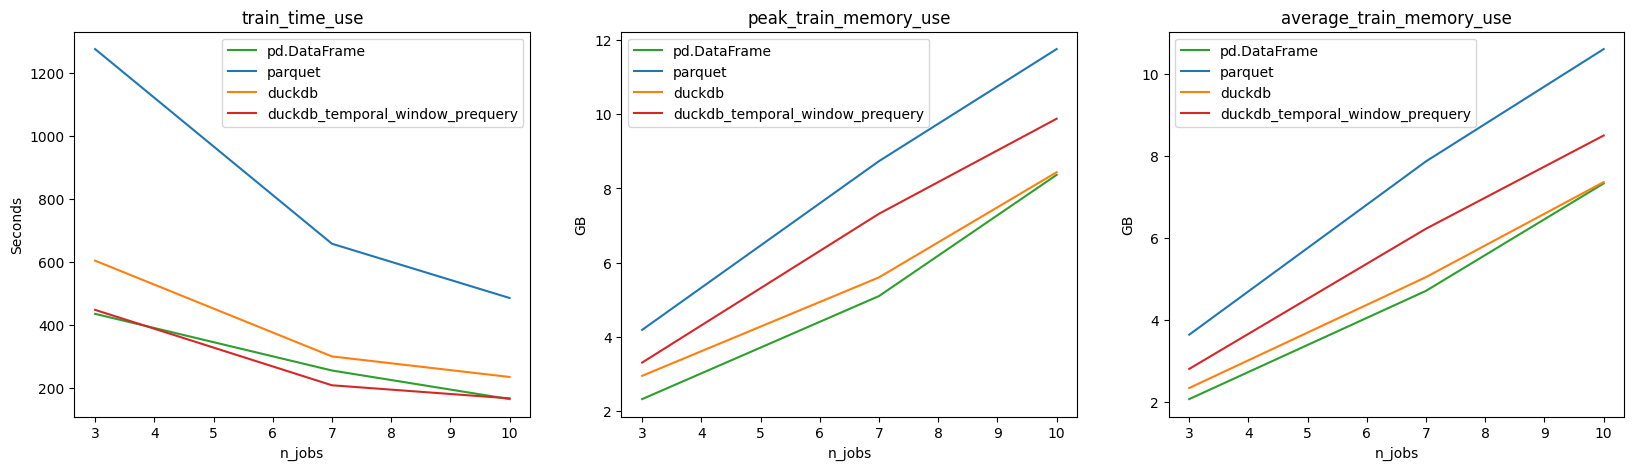

In [40]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
for var_id, var_ in enumerate(['train_time_use','peak_train_memory_use','average_train_memory_use']):
    ax[var_id%3].plot(
        log_df[log_df['method']=='pd.DataFrame']['n_jobs'],
        log_df[log_df['method']=='pd.DataFrame'][var_],
        label='pd.DataFrame', c='tab:green'
    )
    ax[var_id%3].plot(
        log_df[log_df['method']=='parquet']['n_jobs'],
        log_df[log_df['method']=='parquet'][var_],
        label='parquet', c='tab:blue'
    )

    ax[var_id%3].plot(
        log_df[log_df['method']=='duckdb']['n_jobs'],
        log_df[log_df['method']=='duckdb'][var_],
        label='duckdb', c='tab:orange'
    )

    ax[var_id%3].plot(
        log_df[log_df['method']=='duckdb_temporal_window_prequery']['n_jobs'],
        log_df[log_df['method']=='duckdb_temporal_window_prequery'][var_],
        label='duckdb_temporal_window_prequery', c='tab:red'
    )
    
    ax[var_id%3].legend()
    ax[var_id%3].set_title(var_)
    if 'time' in var_:
        ax[var_id%3].set_ylabel('Seconds')
    elif 'memory' in var_:
        ax[var_id%3].set_ylabel('GB')
    ax[var_id%3].set_xlabel('n_jobs')


plt.subplots_adjust(wspace=0.2, hspace=0.3)


Ok! So it does seem like that on this small dataset, neither using parquet nor duckdb will help us improve the memory and speed. This is likely because this dataframe is only 90MB large, and can perfectly fit into the memory. Besides, we set `max_mem=500MB` for duckdb setting, which is much larger than `90MB`, meaning that duckdb is likely happily taking the whole dataset into memory without lazy loading.

So in conclusion:
1. If you have a small dataframe, use pd.DataFrame as input is good because it is fast and consume less memory (because duckdb will create in-memory database for that file, which actually takes more memory compared to the benefit of lazy-loading).
2. If you have large dataframe (say, >2GB) and want to parallel compute among processors, use duckdb (see the large-dataset test below).


## On larger dataset

While duckdb input does not seem to be useful for a small dataset of 90MB, we anticipate that it will help a lot with memory on large dataset. And here is the experiment.

In [41]:
# Make the data 10x bigger
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)
data = pd.concat([data for _ in range(10)], axis=0).reset_index(drop=True)
X = data.drop('count', axis=1)
y = data[['count']]

from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                        Spatio1 = 'longitude',
                                                        Spatio2 = 'latitude',
                                                        Temporal1 = 'DOY',
                                                        Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                        random_state=42, test_size=0.3)

del X, y, data

import tempfile, duckdb
from stemflow.utils.generate_random import generate_random_saving_code

# We first create a temporary folder to save our database. However, you can save this database into a more permanent location if you want to use it in a long run.
tmp_dir = os.path.join(tempfile.gettempdir(), f'{generate_random_saving_code()}')
os.makedirs(tmp_dir)

X_train_parquet_path = os.path.join(tmp_dir, 'X_train.parquet')
X_train.to_parquet(X_train_parquet_path, index=True)

X_test_parquet_path = os.path.join(tmp_dir, 'X_test.parquet')
X_test.to_parquet(X_test_parquet_path, index=True)

y_train_parquet_path = os.path.join(tmp_dir, 'y_train.parquet')
y_train.to_parquet(y_train_parquet_path, index=True)

y_test_parquet_path = os.path.join(tmp_dir, 'y_test.parquet')
y_test.to_parquet(y_test_parquet_path, index=True)


# Make a cpy
X_train_new = X_train.copy()
X_test_new = X_test.copy()
y_train_new = y_train.copy()
y_test_new = y_test.copy()

# Make the index an actual column in that dataframe
X_train_new['__index_level_0__'] = X_train_new.index
X_test_new['__index_level_0__'] = X_test_new.index
y_train_new['__index_level_0__'] = y_train_new.index
y_test_new['__index_level_0__'] = y_test_new.index

# Dump X_train to duckdb
target_X_train_path = os.path.join(tmp_dir, 'X_train.duckdb')
with duckdb.connect(target_X_train_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM X_train_new;") # I use tmp as the table name, but you can use any. Make sure there is only one table in this .duckdb file
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it
    con.execute("CREATE INDEX IF NOT EXISTS idx_doy ON tmp(DOY);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_longitude ON tmp(longitude);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_latitude ON tmp(latitude);")

target_y_train_path = os.path.join(tmp_dir, 'y_train.duckdb')
with duckdb.connect(target_y_train_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM y_train_new;")
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it

target_X_test_path = os.path.join(tmp_dir, 'X_test.duckdb')

with duckdb.connect(target_X_test_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM X_test_new;")
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it
    con.execute("CREATE INDEX IF NOT EXISTS idx_doy ON tmp(DOY);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_longitude ON tmp(longitude);")
    con.execute("CREATE INDEX IF NOT EXISTS idx_latitude ON tmp(latitude);")

target_y_test_path = os.path.join(tmp_dir, 'y_test.duckdb')
with duckdb.connect(target_y_test_path) as con:
    con.execute("CREATE TABLE tmp AS SELECT * FROM y_test_new;")
    con.execute("CREATE INDEX IF NOT EXISTS idx_idx ON tmp(__index_level_0__);") # These indexes will make later query much faster so worth doing it



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Now the `X_train.duckdb` is 797MB large on disk, instead of 90MB in the original case

### Run test: Training using pd.DataFrame, duckdb, and pandas. Increasing n_jobs

In [42]:
log_list=[]

In [45]:
ensemble_fold = 10 # To speed-up, reduce it to 10 ensemble folds
n_jobs_list = [3, 7, 10]

for n_jobs in tqdm(n_jobs_list):
    
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train, y_train)
    
    # pd.DataFrame
    log_list.append({
        'method':'pd.DataFrame',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading

    # # Parquet
    # model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    # train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train_parquet_path, y_train_parquet_path)
    # log_list.append({
    #     'method':'parquet',
    #     'n_jobs':n_jobs,
    #     'lazy_loading':True,
    #     'train_time_use':train_time_use,
    #     'peak_train_memory_use':peak_train_memory_use,
    #     'average_train_memory_use':average_train_memory_use
    # })
    # del model_lazyloading
    
    # Duckdb
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, target_X_train_path, target_y_train_path)
    log_list.append({
        'method':'duckdb',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    
    # Duckdb but tempo
    model_lazyloading = make_model_lazyloading(ensemble_fold, n_jobs, '500MB')
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, target_X_train_path, target_y_train_path, temporal_window_prequery=True)
    log_list.append({
        'method':'duckdb_temporal_window_prequery',
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use
    })
    del model_lazyloading
    
    

  0%|          | 0/2 [00:00<?, ?it/s]

Training: 100%|██████████| 10/10 [04:10<00:00, 25.01s/it]


Training finish!


Training: 100%|██████████| 10/10 [27:58<00:00, 167.87s/it]


Training finish!


Training: 100%|██████████| 10/10 [04:26<00:00, 26.60s/it]


Training finish!


Training: 100%|██████████| 10/10 [02:37<00:00, 15.79s/it]


Training finish!


Training: 100%|██████████| 10/10 [20:22<00:00, 122.29s/it]


Training finish!


Training: 100%|██████████| 10/10 [02:52<00:00, 17.30s/it]


Training finish!


We did not train models with parquet input here since they are pretty time-consuming.

In [46]:
log_df = pd.DataFrame(log_list)
log_df.to_csv('tmp_log_df_three_method_compare_changing_n_jobs_large_data.csv', index=False)
log_df

,method,n_jobs,lazy_loading,train_time_use,peak_train_memory_use,average_train_memory_use
0,pd.DataFrame,3,True,551.802596,5.205802,2.803865
1,duckdb,3,True,3041.098778,6.074677,4.496988
2,duckdb_temporal_window_prequery,3,True,578.773793,9.111948,7.126898
3,pd.DataFrame,7,True,293.093873,17.819515,13.706751
4,duckdb,7,True,1722.597101,10.310321,7.546375
5,duckdb_temporal_window_prequery,7,True,310.638719,12.230624,9.112729
6,pd.DataFrame,10,True,184.838532,22.265324,18.900601
7,duckdb,10,True,1251.522821,12.514505,10.963082
8,duckdb_temporal_window_prequery,10,True,205.598417,14.070451,11.068236


### Plotting experiment results

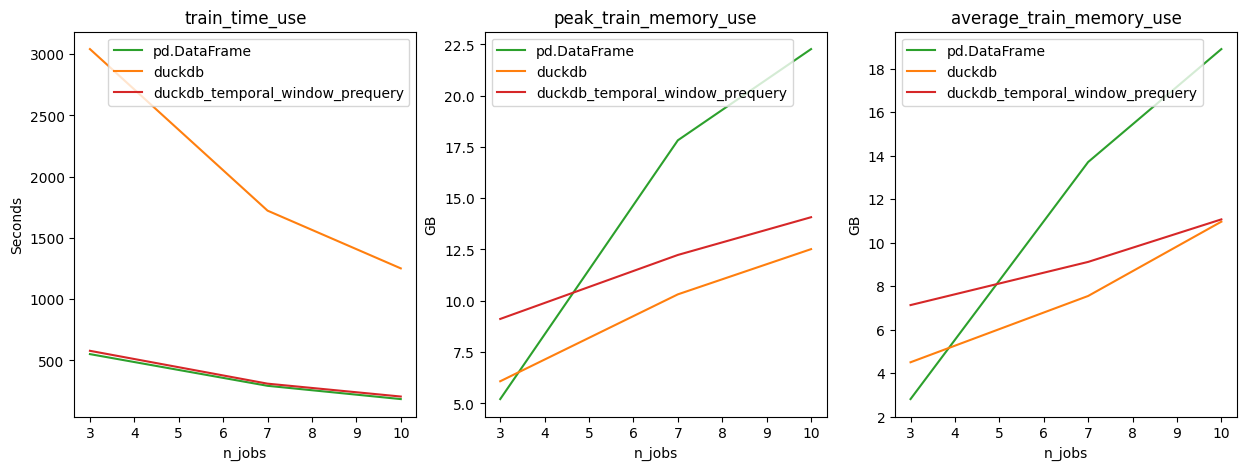

In [48]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for var_id, var_ in enumerate(['train_time_use','peak_train_memory_use','average_train_memory_use']):
    ax[var_id%3].plot(
        log_df[log_df['method']=='pd.DataFrame']['n_jobs'],
        log_df[log_df['method']=='pd.DataFrame'][var_],
        label='pd.DataFrame', c='tab:green'
    )

    ax[var_id%3].plot(
        log_df[log_df['method']=='duckdb']['n_jobs'],
        log_df[log_df['method']=='duckdb'][var_],
        label='duckdb', c='tab:orange'
    )
    
    ax[var_id%3].plot(
        log_df[log_df['method']=='duckdb_temporal_window_prequery']['n_jobs'],
        log_df[log_df['method']=='duckdb_temporal_window_prequery'][var_],
        label='duckdb_temporal_window_prequery', c='tab:red'
    )
    
    ax[var_id%3].legend()
    ax[var_id%3].set_title(var_)
    if 'time' in var_:
        ax[var_id%3].set_ylabel('Seconds')
    elif 'memory' in var_:
        ax[var_id%3].set_ylabel('GB')
    ax[var_id%3].set_xlabel('n_jobs')


plt.subplots_adjust(wspace=0.2, hspace=0.3)


This is exactly expected. With large dataset, you can set a memory threshold smaller than that as duckdb configuration, and duckdb will limit the memory use, with a trade-off of slower speed. We can achieve a similar performance using `temporal_windlow_prequery` with slightly higher memory usage than pure `duckdb`

## Concluding mark

1. For small dataset (<1GB), use `pandas` object as input.

1. For large dataset (>1GB), use `duckdb` + `temporal_window_prequery` if you can tolerate slightly higher memory load.

1. For super large dataset (>100GB), use `duckdb`.

1. Do not use `parquet` as input if you don't have to.

**Please open an issue if you have any question**

**Cheers!**


In [49]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2025-10-13T12:11:28.202013-05:00

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

stemflow    : 1.1.5
numpy       : 1.26.4
scipy       : 1.16.1
pandas      : 2.2.3
xgboost     : 3.0.4
tqdm        : 4.65.0
matplotlib  : 3.10.0
h3pandas    : 0.3.0
geopandas   : 1.0.1
scikit-learn: 1.5.2

